In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime
from matplotlib import pyplot as plt

%run ./data_loading.ipynb

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=10*10*12, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=9)
        
    def forward(self, X):
        X = self.pool(self.relu(self.conv1(X)))
        X = self.pool(self.relu(self.conv2(X)))
        X = X.view(-1, 10*10*12)
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [3]:
net = Net().float()
if torch.cuda.is_available():
    net = net.cuda()

In [4]:
loss_f = nn.CrossEntropyLoss().cpu()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [5]:
cls_data = ClassroomDataset()

In [6]:
cls_data.__len__()

3200

In [7]:
batch_size = 5
cls_data_loader = DataLoader(cls_data, batch_size=batch_size, shuffle=True)

In [8]:
for epoch in range(20):
    running_loss = 0.0
    for i, data in tqdm(enumerate(cls_data_loader, 0)):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch:', epoch, ', loss:', running_loss * batch_size / cls_data.__len__())

640it [00:08, 75.23it/s]


epoch: 0 , loss: 1.4444357027474326


640it [00:08, 73.10it/s]


epoch: 1 , loss: 0.6750336795172188


640it [00:08, 73.56it/s]


epoch: 2 , loss: 0.5111253665727418


640it [00:08, 76.03it/s]


epoch: 3 , loss: 0.38929194848687987


640it [00:07, 80.02it/s]


epoch: 4 , loss: 0.3073096747828458


640it [00:08, 74.86it/s]


epoch: 5 , loss: 0.23613183582160674


640it [00:08, 75.86it/s]


epoch: 6 , loss: 0.18206149748659756


640it [00:08, 73.84it/s]


epoch: 7 , loss: 0.13756314279011833


640it [00:08, 72.17it/s]


epoch: 8 , loss: 0.12141011146232188


640it [00:10, 60.86it/s]


epoch: 9 , loss: 0.0809228499007176


640it [00:10, 58.43it/s]


epoch: 10 , loss: 0.06457245210095941


640it [00:10, 60.30it/s]


epoch: 11 , loss: 0.04551374067792864


640it [00:10, 59.80it/s]


epoch: 12 , loss: 0.02339091304353822


640it [00:10, 58.66it/s]


epoch: 13 , loss: 0.016936892992934115


640it [00:10, 59.59it/s]


epoch: 14 , loss: 0.013701277488507423


640it [00:10, 61.17it/s]


epoch: 15 , loss: 0.010759012450192684


640it [00:10, 58.86it/s]


epoch: 16 , loss: 0.00779613563936733


640it [00:10, 60.35it/s]


epoch: 17 , loss: 0.006294934259711837


640it [00:10, 61.29it/s]


epoch: 18 , loss: 0.00472640891249968


640it [00:10, 61.60it/s]


epoch: 19 , loss: 0.004465295567320682


In [9]:
p = "weights/" + str(datetime.datetime.now()).split(".")[0].replace(':','_') + ".pth"
p

'weights/2019-11-27 16_30_16.pth'

In [10]:
torch.save(net.state_dict(), p)

# Testing

In [11]:
weights = "2019-11-27 15_11_38.pth"
PATH = "weights/" + weights
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
dataiter = iter(cls_data_loader)

In [13]:
images, labels = dataiter.next()
images_cpu = images.cpu().numpy()

In [14]:
len(images_cpu[0][0])

50

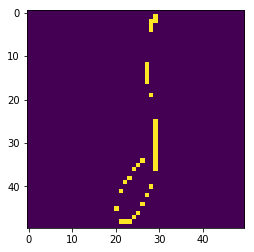

In [15]:
plt.imshow(images_cpu[3][0])

In [16]:
outputs = net(images.cpu())
outputs

tensor([[-12.2696, -12.4976, -14.9389,  -9.8146, -14.8837,   3.0765,  52.4354,
          19.2147,  -1.2011],
        [-16.4454, -10.4365, -12.0093,  -6.0797,   3.3766,  -6.4126,  20.0601,
          38.7419, -10.8080],
        [-22.9078,   8.5448, -13.1172,  32.5969,   0.2614,  -6.7222,   1.7357,
          -6.2114,  -0.2758],
        [ -5.5303,  -3.3062,  -1.4281,  -3.7438,   2.7626,  -2.1127,   3.7869,
          12.7326,  -2.9923],
        [-16.6031,  -6.7155,  13.4029, -11.3958,  22.7450, -14.3951,   0.3806,
          13.8799,  -6.3243]], grad_fn=<AddmmBackward>)

In [17]:
_, predicted = torch.max(outputs, 1)
predicted[0]

tensor(6)

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in cls_data_loader:
        images, labels = data
        outputs = net(images.cpu())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cpu()).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 99 %


*__The model was able to overfit the data successfully. That means our model works. Next iteration we divide into train and test sets__*